<a href="https://colab.research.google.com/github/AhmedSamySaad/MAC/blob/master/High_acc_XR_ELBOW_XR_FINGER_XR_WRIST_for_Validate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook has been written to work on MURA dataset trained models **for any of those purposes** : ***models evaluation***, ***get models infrances*** and for ***deploy***.

- Ready to work on three models : 
    - XR_ELBOW
    - XR_FINGER
    - XR_WRIST
- Ready to work on three "Workplace", based on user choose:
    - "Kaggle" : data is located on the same workplace. *(Data must be first imported maunally to "input" folder befor run "data_preparation" function)*
    - "Local"  : data must be located on the same workplace with same shape of other workplace.
    - "Google Colab" : data imported from two sources [user choose one to download from]:
          - "Stanford" 
          - "Kaggle"

    - There will be a global utils functions that defined based on choosen workplace and it requires that the data be as shown in the image below on all workplces:


  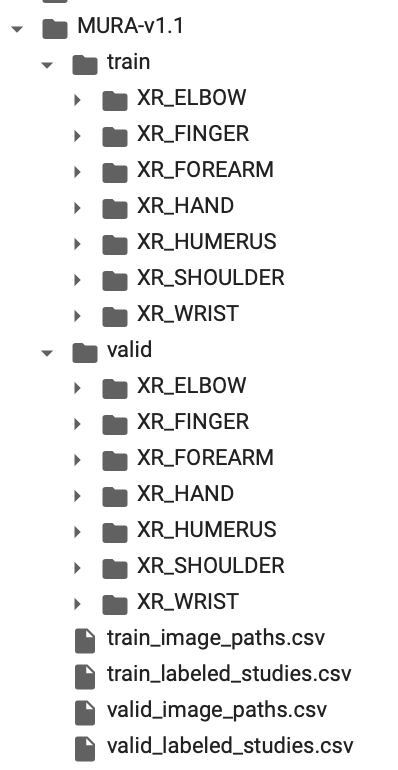


### Some Prerequisites:
(it require to restart plateform kernal after it)

In [32]:
!pip uninstall tensorflow -y
!pip uninstall keras -y
# for best performance, choose (based on choosen workplace) : tensorflow-gpu===2.3.0 OR tensorflow===2.3.0
# !pip install tensorflow-gpu===2.3.0
!pip install tensorflow===2.3.0
!pip install keras==2.4.3

# to solve error of "cannot import name 'Resize' from 'albumentations.augmentations.transforms'" of the next cell
!pip install albumentations==0.5.2

Found existing installation: tensorflow 2.3.0
Uninstalling tensorflow-2.3.0:
  Successfully uninstalled tensorflow-2.3.0
Found existing installation: Keras 2.4.3
Uninstalling Keras-2.4.3:
  Successfully uninstalled Keras-2.4.3
  Using cached tensorflow-2.3.0-cp37-cp37m-manylinux2010_x86_64.whl (320.4 MB)


  Using cached Keras-2.4.3-py2.py3-none-any.whl (36 kB)


In [1]:
import tensorflow as tf
print("tf version: ",tf.__version__)
# tf.keras.__version__
print("tf.keras version: ",tf.keras.__version__)
import keras
print("keras.__version__: ",keras.__version__)
# !albumentations --V

tf version:  2.3.0
tf.keras version:  2.4.0
keras.__version__:  2.4.3


In [4]:
import tensorflow as tf
import os
import pandas as pd
import cv2
from skimage.transform import rescale, resize
import keras
import numpy as np
from sklearn.utils import class_weight
# import tensorflow_addons as tfa
import pickle
from skimage.io import imread
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import datetime
import numpy as np

## Getting MURA dataset from different resources:

In [42]:
def data_preparation (Workplace="local"):

  '''
      - This function prepare MURA dataset to be suitable to work on three different "Workplaces". 
      - Takes "one" argument : "kaggle" OR "colab" OR [The defult] "local".
      - Each "Workplace" is:
          - the source to get the dataset from.
          - the place the code will work on.
      - Based on "Workplace" choosen, this function define "Global" utils functions sutable to the "Workplace".

      - Working Steps:
        - Download the dataset from the source ["Kaggle" contains the dataset on it and it must be imported manualy]
        - Print some informations about the dataset.
        - Define "Global" utils functions sutable to the "Workplace", those functions are:
              - "filenames_kag" for kaggle platform OR  "filenames" for colab and local platform
              - "crop_center" 
  '''
  if (Workplace == "kaggle"):
    print("if test")
    '''
        Data must be first imported maunally to "input" folder befor run this function
    '''
    ###### Getting some informations about the dataset ######
    print("Getting some informations about the dataset: ")
    print("######## 1s : Patients for each part: ########")
    train_dir = "../input/mura-v11/MURA-v1.1/train"
    validation_dir = '../input/mura-v11/MURA-v1.1/valid'
    print("Total Training patients: ")
    for i in os.listdir(train_dir) :
      print('Total Training patients at {}:'.format(i),len(os.listdir("../input/mura-v11/MURA-v1.1/train/{}".format(i))))
    print("\nTotal Validation patients: ")
    for i in os.listdir(validation_dir) :
      print('Total Validation patients at {}:'.format(i),len(os.listdir("../input/mura-v11/MURA-v1.1/valid/{}".format(i))))

    print("########\n2d : Total pictures for each part: ########")  # to complete
    print("# to complete")
    # print("Total Training pics: ")
    # for part in os.listdir(train_dir) :
    #     imgs,labels= filenames(part=part) # train data
    #     vimgs,vlabels= filenames(part=part,train=False) # validation data

    #     print('{} Training positive :'.format(part),labels.count('positive'),'\n','{} Training negative :'.format(part),labels.count('negative'))
    #     training_data= labels.count('positive')+labels.count('negative')
    #     print("Total Training Data at {}: ".format(part), training_data)
    #     print('\n')
    #     print('{} Validation positive :'.format(part),vlabels.count('positive'),'\n','{} Validation negative :'.format(part),vlabels.count('negative'))
    #     validation_data= vlabels.count('positive')+vlabels.count('negative')
    #     print("Total Validation Data: ", validation_data)

    ###### Define Global utils functions ######
    #To get the filenames for a task
    global filenames_kag
    def filenames_kag(part,train=True):
        root='../input/mura-v11/'
        if train:
            csv_path="../input/mura-v11/MURA-v1.1/train_image_paths.csv"
        else:
            csv_path="../input/mura-v11/MURA-v1.1/valid_image_paths.csv"
        
        with open(csv_path, 'rb') as F:
            d = F.readlines()
            if part == 'all':
                imgs = [root + str(x, encoding='utf-8').strip() for x in d] 
            else:
                imgs = [root + str(x, encoding='utf-8').strip() for x in d if
                                str(x, encoding='utf-8').strip().split('/')[2] == part]

        #imgs= [x.replace("/", "\\") for x in imgs]
        labels= [x.split('_')[-1].split('/')[0] for x in imgs]
        return imgs,labels
  ################################### End of part ONE ######################################## 
  elif (Workplace == "colab-stanford"):
    '''
      There are two ways to import data to "Google Colab":
        1-> [the easy one - but need more time] : from "stanford".
        2-> [The fastest, but it needs some proactive steps to implement] : from "Kaggle".
    '''
    ##################### 1st, from "stanford" #####################
    ###### Download the dataset ######
    import os
    !wget https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
    from google.colab import files

    # Unzip the dataset
    import zipfile
    !chmod 777 *
    zip_ref = zipfile.ZipFile("./MURA-v1.1.zip", 'r')
    zip_ref.extractall()
    zip_ref.close()

    ###### Getting some informations about the dataset ######
    print("Getting some informations about the dataset: ")
    print("######## 1s : Patients for each part: ########")
    train_dir = "MURA-v1.1/train"
    validation_dir = 'MURA-v1.1/valid'
    print("Total Training patients: ")
    for i in os.listdir(train_dir) :
      print('Total Training patients at {}:'.format(i),len(os.listdir("MURA-v1.1/train/{}".format(i))))
    print("\nTotal Validation patients: ")
    for i in os.listdir(validation_dir) :
      print('Total Validation patients at {}:'.format(i),len(os.listdir("MURA-v1.1/valid/{}".format(i))))
    
    print("########\n2d : Total pictures for each part: ########")  # to complete
    print("# to complete")
    # print("Total Training pics: ")
    # for part in os.listdir(train_dir) :
    #     imgs,labels= filenames(part=part) # train data
    #     vimgs,vlabels= filenames(part=part,train=False) # validation data

    #     print('{} Training positive :'.format(part),labels.count('positive'),'\n','{} Training negative :'.format(part),labels.count('negative'))
    #     training_data= labels.count('positive')+labels.count('negative')
    #     print("Total Training Data at {}: ".format(part), training_data)
    #     print('\n')
    #     print('{} Validation positive :'.format(part),vlabels.count('positive'),'\n','{} Validation negative :'.format(part),vlabels.count('negative'))
    #     validation_data= vlabels.count('positive')+vlabels.count('negative')
    #     print("Total Validation Data: ", validation_data)

  ################################### End of part TWO ######################################## 
  elif (Workplace == "colab-kaggle"):
    '''
      There are two ways to import data to "Google Colab":
        1-> [the easy one - but need more time] : from "stanford".
        2-> [The fastest, but it needs some proactive steps to implement] : from "Kaggle".
    '''
    ##################### 2nd, from "kaggle" #####################
    ###### Download the dataset ######
    # These datasets are not part of any competition. You can download these datasets by:
    from getpass import getpass
    import os
    # user = 'ahmadsamiratta'
    # key = '89c018ada8ed8617a11d12e9a155d329'

    # if '.kaggle' not in os.listdir('/root'):
    #     !mkdir ~/.kaggle
    # !touch /root/.kaggle/kaggle.json
    # !chmod 666 /root/.kaggle/kaggle.json
    # with open('/root/.kaggle/kaggle.json', 'w') as f:
    #     f.write('{"username":"%s","key":"%s"}' % (user, key))
    # !chmod 600 /root/.kaggle/kaggle.json
    !kaggle datasets download cjinny/mura-v11

    # Unzip the dataset
    import zipfile
    !chmod 777 *
    zip_ref = zipfile.ZipFile("./mura-v11.zip", 'r')
    zip_ref.extractall() #"tmp/"
    zip_ref.close()

    ###### Getting some informations about the dataset ######
    print("Getting some informations about the dataset: ")
    print("######## 1s : Patients for each part: ########")
    train_dir = "MURA-v1.1/train"
    validation_dir = 'MURA-v1.1/valid'
    print("Total Training patients: ")
    for i in os.listdir(train_dir) :
      print('Total Training patients at {}:'.format(i),len(os.listdir("MURA-v1.1/train/{}".format(i))))
    print("\nTotal Validation patients: ")
    for i in os.listdir(validation_dir) :
      print('Total Validation patients at {}:'.format(i),len(os.listdir("MURA-v1.1/valid/{}".format(i))))
    
    print("\n########2d : Total pictures for each part: ########")  # to complete
    print("# to complete")
    # print("Total Training pics: ")
    # for part in os.listdir(train_dir) :
    #     imgs,labels= filenames(part=part) # train data
    #     vimgs,vlabels= filenames(part=part,train=False) # validation data

    #     print('{} Training positive :'.format(part),labels.count('positive'),'\n','{} Training negative :'.format(part),labels.count('negative'))
    #     training_data= labels.count('positive')+labels.count('negative')
    #     print("Total Training Data at {}: ".format(part), training_data)
    #     print('\n')
    #     print('{} Validation positive :'.format(part),vlabels.count('positive'),'\n','{} Validation negative :'.format(part),vlabels.count('negative'))
    #     validation_data= vlabels.count('positive')+vlabels.count('negative')
    #     print("Total Validation Data: ", validation_data)

  ################################### End of part THREE ######################################## 
  else : # from local
    print("Code of local Workplace is not ready, Please Write it.") 
    ###### Getting some informations about the dataset ######
    print("Getting some informations about the dataset: ")
    print("######## 1s : Patients for each part: ########")
    train_dir = "MURA-v1.1/train"
    validation_dir = 'MURA-v1.1/valid'
    print("Total Training patients: ")
    for i in os.listdir(train_dir) :
      print('Total Training patients at {}:'.format(i),len(os.listdir("MURA-v1.1/train/{}".format(i))))
    print("\nTotal Validation patients: ")
    for i in os.listdir(validation_dir) :
      print('Total Validation patients at {}:'.format(i),len(os.listdir("MURA-v1.1/valid/{}".format(i))))
    
    print("########\n2d : Total pictures for each part: ########")  # to complete
    print("# to complete")
    # print("Total Training pics: ")
    # for part in os.listdir(train_dir) :
    #     imgs,labels= filenames(part=part) # train data
    #     vimgs,vlabels= filenames(part=part,train=False) # validation data

    #     print('{} Training positive :'.format(part),labels.count('positive'),'\n','{} Training negative :'.format(part),labels.count('negative'))
    #     training_data= labels.count('positive')+labels.count('negative')
    #     print("Total Training Data at {}: ".format(part), training_data)
    #     print('\n')
    #     print('{} Validation positive :'.format(part),vlabels.count('positive'),'\n','{} Validation negative :'.format(part),vlabels.count('negative'))
    #     validation_data= vlabels.count('positive')+vlabels.count('negative')
    #     print("Total Validation Data: ", validation_data)

  ################################### End of part FOUR ######################################## 
  ###### Define Global utils functions ######
  '''
     These "filenames" function is defined to use in case of:
        1 -> colab workplace regardless of the data source ("Stanford" or "Kaggle")
        2 -> local workplace
  '''

  #To get the filenames for a task
  global filenames
  def filenames(part,train=True):
      if train:
          csv_path="MURA-v1.1/train_image_paths.csv"
      else:
          csv_path="MURA-v1.1/valid_image_paths.csv"
      
      with open(csv_path, 'rb') as F:
          d = F.readlines()
          if part == 'all':
              imgs = [str(x, encoding='utf-8').strip() for x in d] 
          else:
              imgs = [str(x, encoding='utf-8').strip() for x in d if
                              str(x, encoding='utf-8').strip().split('/')[2] == part]

      #imgs= [x.replace("/", "\\") for x in imgs]
      labels= [x.split('_')[-1].split('/')[0] for x in imgs]
      return imgs,labels

  '''
    These "crop_center" is defined to use in all cases (local, kaggle and colab)
  '''

  #To icrop a image from center
  global crop_center
  def crop_center(img,cropx,cropy):
      y,x,_ = img.shape
      startx = x//2-(cropx//2)
      starty = y//2-(cropy//2)    
      return img[starty:starty+cropy,startx:startx+cropx]

## General functions to use regardless of the "Workplace":
    1 -> My_Custom_Generator(keras.utils.Sequence)
    2 -> prep_val(workplace="local",part="XR_ELBOW")
    3 -> val_preprocess()

########################################
# One of the three listed below:
    - XR_ELBOW
    - XR_FINGER
    - XR_WRIST
########################################

In [7]:
# **Creating data generator for training and testiing with augmentation**
class My_Custom_Generator(keras.utils.Sequence) :
  
  def __init__(self, image_filenames, labels, batch_size,transform) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.t= transform
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    x=[]
    for file in batch_x:
        img= imread(file)
        img= self.t(image=img)["image"]
        img= resize(img,(300,300,3))
        img= crop_center(img,224,224)
        x.append(img)
    x=np.array(x)/255.0
    y= np.array(batch_y)
    return x,y


# **Getting data using the utility functions**
def prep_val(workplace="local",part="XR_ELBOW"):
  '''
  - This function is to prepare validation data to be used
  - function parameters:
      -> workplace : plateform to work on
      -> part      : bone part that trained model trained on
  - function returns:
      -> vimgs     : the validation data pictures
      -> vy_data   : the validation data labels
  '''
  # part='XR_ELBOW' # part to work with
  if (workplace == "kaggle"):
    imgs,labels= filenames_kag(part=part) # train data
    vimgs,vlabels= filenames_kag(part=part,train=False) # validation data
  elif (workplace == "colab") or (workplace == "local") or (workplace == "colab-stanford") or (workplace ==  "colab-kaggle"): # for local or colab workplace
    imgs,labels= filenames(part=part) # train data
    vimgs,vlabels= filenames(part=part,train=False) # validation data

  print('{} Training positive :'.format(part),labels.count('positive'),'\n','{} Training negative :'.format(part),labels.count('negative'))
  training_data= labels.count('positive')+labels.count('negative')
  print(">> Total Training Data at {}: ".format(part), training_data)
  print('\n')
  print('{} Validation positive :'.format(part),vlabels.count('positive'),'\n','{} Validation negative :'.format(part),vlabels.count('negative'))
  validation_data= vlabels.count('positive')+vlabels.count('negative')
  print(">> Total Validation Data: ", validation_data)

  # y_data= [0 if x=='positive' else 1 for x in labels] # train data
  # y_data= tf.keras.utils.to_categorical(y_data) # 
  vy_data= [0 if x=='positive' else 1 for x in vlabels]    # produce a column array ([0,1,1,0,0,....])
  vy_data= tf.keras.utils.to_categorical(vy_data)          # convert it to the shape of two column
  return vimgs , vy_data,  # imgs, labels 


def val_preprocess():
  from albumentations import ToFloat, Compose, CLAHE
  return Compose([
                  ToFloat(max_value=255)
                  # CLAHE(p=1.0, clip_limit=2.0)
                ])

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
XR_ELBOW_path = "/content/drive/MyDrive/My-MURA-Trained-Models/XR_ELBOW/MURA_model@XR_ELBOW-after_18_epoch.h5"  # from google drive
# XR_ELBOW_path = "" # from local

XR_FINGER_path = "/content/drive/MyDrive/My-MURA-Trained-Models/XR_FINGER/MURA_model@XR_FINGER.h5" # from google drive
# XR_FINGER_path = "" # from local

XR_WRIST_path ="/content/drive/MyDrive/My-MURA-Trained-Models/XR_WRIST/MURA_model@XR_WRIST-2.h5" # from google drive
# XR_WRIST_path = "" # from local


def model_test(model_path,part,workplace,batch_size):
  # import needed libraries
  from sklearn.metrics import confusion_matrix,classification_report
  import seaborn as sn  

  # prepare validation data
  vimgs , vy_data = prep_val(workplace=workplace,part=part)
  # call preprocess function on validation data
  AUGMENTATIONS_TEST = val_preprocess()

  #vimgs, vy_data = shuffle(vimgs, vy_data)
  my_validation_batch_generator = My_Custom_Generator(vimgs, vy_data, batch_size,AUGMENTATIONS_TEST)

  # load the retrained model
  model = keras.models.load_model(model_path)

  # get predection from the loaded model
  y_pred=  model.predict(my_validation_batch_generator)

  # Confusion matrix
  print("0 : positive", "\n", "1 : negative")
  pred_labels = np.argmax(y_pred,axis=1)   # choose the largest property to be the predection label
  true_labels = np.argmax(vy_data,axis=1)
  cm = confusion_matrix(true_labels,pred_labels)
  sn.heatmap(cm,annot=True,fmt='d')
  plt.show()

  # some performance analysis
  print(classification_report(true_labels,pred_labels))

  # prepare the labels in the shape of "" and "" to be printed as a "RESULT"
  pred_char_labels= ['positive' if x==0 else 'negative' for x in pred_labels] 
  true_char_labels= ['positive' if x==0 else 'negative' for x in true_labels] 

  # print the "RESULT"
  for index, (pre,true) in enumerate(zip(pred_char_labels[:10],true_char_labels[:10])):
    if (pre == true):
      print("Good predection: ", pre)
    else:
      print("Wrong predection:", pre,",The true is:", true)

XR_ELBOW Training positive : 2006 
 XR_ELBOW Training negative : 2925
>> Total Training Data at XR_ELBOW:  4931


XR_ELBOW Validation positive : 230 
 XR_ELBOW Validation negative : 235
>> Total Validation Data:  465


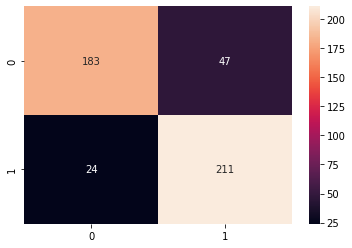

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       230
           1       0.82      0.90      0.86       235

    accuracy                           0.85       465
   macro avg       0.85      0.85      0.85       465
weighted avg       0.85      0.85      0.85       465

Good predection:  positive
Good predection:  positive
Good predection:  positive
Good predection:  positive
Good predection:  positive
Good predection:  positive
Good predection:  positive
Good predection:  positive
Wrong predection: negative ,The true is: positive
Wrong predection: negative ,The true is: positive


In [38]:
model_test(XR_ELBOW_path,"XR_ELBOW","colab-kaggle",32)

XR_FINGER Training positive : 1968 
 XR_FINGER Training negative : 3138
>> Total Training Data at XR_FINGER:  5106


XR_FINGER Validation positive : 247 
 XR_FINGER Validation negative : 214
>> Total Validation Data:  461


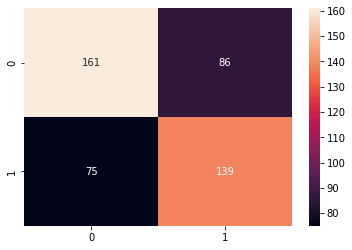

              precision    recall  f1-score   support

           0       0.68      0.65      0.67       247
           1       0.62      0.65      0.63       214

    accuracy                           0.65       461
   macro avg       0.65      0.65      0.65       461
weighted avg       0.65      0.65      0.65       461

Good predection:  positive
Wrong predection: negative ,The true is: positive
Good predection:  positive
Good predection:  positive
Good predection:  positive
Good predection:  positive
Good predection:  positive
Good predection:  positive
Good predection:  positive
Wrong predection: negative ,The true is: positive


In [39]:
model_test(XR_FINGER_path,"XR_FINGER","colab-kaggle",32)

XR_WRIST Training positive : 3987 
 XR_WRIST Training negative : 5765
>> Total Training Data at XR_WRIST:  9752


XR_WRIST Validation positive : 295 
 XR_WRIST Validation negative : 364
>> Total Validation Data:  659


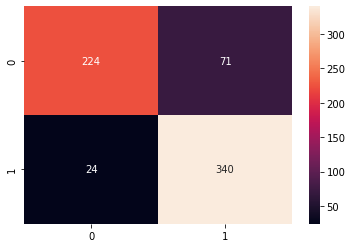

              precision    recall  f1-score   support

           0       0.90      0.76      0.83       295
           1       0.83      0.93      0.88       364

    accuracy                           0.86       659
   macro avg       0.87      0.85      0.85       659
weighted avg       0.86      0.86      0.85       659

Good predection:  positive
Good predection:  positive
Good predection:  positive
Good predection:  positive
Good predection:  positive
Good predection:  positive
Good predection:  positive
Good predection:  positive
Good predection:  positive
Good predection:  positive


In [40]:
model_test(XR_WRIST_path,"XR_WRIST","colab-kaggle",32)